## Blatt 7 

### Nummer 1 a)

In [81]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate

Hier werden die Daten eingelesen.

In [82]:
params = pd.read_hdf("./image_parameters_smd_train.hdf5")

Orientiert am Beispiel im Notebook aus der Vorlesung wurden hier einige Features ausgeschlossen, die als irrelevant betrachtet wurden.

In [83]:
y = np.concatenate([np.ones(len(params[params.corsika_run_header_particle_id==1])), np.zeros(len(params[params.corsika_run_header_particle_id==14]))])
forbidden_columns = 'ceres_|mc_|corsika_|run_|source_position_|pointing_|aux_|event_num|incident_angle'

params = params.filter(regex=f'^(?!{forbidden_columns}).*$')
X = params

In [84]:
# Splitten der Daten in Test und Trainingsdaten
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2)

### b)

In [85]:
# Bestimmen der F-Statistik und raussortieren der fünf besten Features
D = []
for i in range(X.shape[1]):
    D = np.append(D, np.abs(X.values[:,i][y==1].mean() - X.values[:,i][y==0].mean())**2/(X.values[:,i][y==1].std()**2 + X.values[:,i][y==0].std()**2))
index = np.argpartition(D, -5)[:-5]
X_test = X_test[X_test.columns.difference(X_test.keys()[index])]
X_train = X_train[X_train.columns.difference(X_train.keys()[index])]
print(f"Die besten fünf Features sind nach dieser Selection '{X_test.keys()[:]}'.")

Die besten fünf Features sind nach dieser Selection 'Index(['concentration_cog', 'leakage1', 'length', 'num_islands', 'width'], dtype='object')'.


### c)

In [86]:
np.random.seed(12)
# Test, welcher estimator am besten ist mittels cross validation auf dem Trainingsdatensatz
rf1 = RandomForestClassifier(n_estimators=1, min_samples_leaf=5, n_jobs=-1)
rf10 = RandomForestClassifier(n_estimators=10, min_samples_leaf=5, n_jobs=-1)
rf100 = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, n_jobs=-1)

score = cross_validate(rf1, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=1   {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf10, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=10  {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf100, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=100 {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

ROC AUC Random Forest n=1   0.561 +/- 0.013
ROC AUC Random Forest n=10  0.599 +/- 0.009
ROC AUC Random Forest n=100 0.615 +/- 0.008


### d)

In [87]:
# Der beste random forrest wurde benutzt um damit tatsächlich die Daten zu trainieren.
rf100.fit(X_train, y_train)
y_prediction_proba = rf100.predict_proba(X_test)

### e)

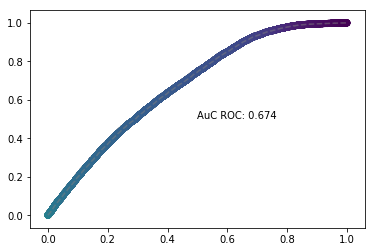

In [88]:
#Evaluierung der Daten mittes ROC Kurve und AUC Wert
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f}')
None

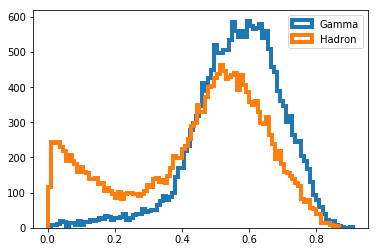

In [89]:
# Plot der Verteilung der Ereignisse entlang des classification scores.
plt.hist(y_prediction_proba[:,1][y_test==1], bins=100, histtype='step', lw=4, label="Gamma")
plt.hist(y_prediction_proba[:,1][y_test==0], bins=100, histtype='step', lw=4, label="Hadron")
plt.legend(loc="best")
None

Daher sieht man, dass es nicht möglich ist, den Untergrund und das Signal zu trennen. 
Bei einem perfekten Klassifizierer wäre Untergrund und Signal komplett voneinander getrennt worden.